# **Analysis of Configurations**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import re


In [ ]:
import os
import re

# Specify the folder path
folder_path = 'C:/Users/shiva/sysml/testing/test_results/config_testing/framerate/'
pattern = r'(\D+_\D+_\d+_\d+_\d)fps(_\D+)'


# Get a list of all files in the folder
file_list = os.listdir(folder_path)

# Iterate through each file
for filename in file_list:
    # Construct the current file path
    current_path = os.path.join(folder_path, filename)
    
    # Check if the current path is a file
    if os.path.isfile(current_path):
        # Extract the file name and extension
        file_name, file_extension = os.path.splitext(filename)
        
        # Use regex to match the pattern and extract the parts
        match = re.match(pattern, file_name)
        
        # Check if the pattern matches
        if match:
            # Extract the relevant parts
            prefix = match.group(1)
            suffix = match.group(2)
            print(prefix)
            print(suffix)
            
            # Construct the new file name
            new_filename = f"{prefix}_1280_720_{suffix}_{file_extension}"
            
            # Construct the new file path
            new_path = os.path.join(folder_path, new_filename)
            
            # Rename the file
            os.rename(current_path, new_path)
            print(f"Renamed {filename} to {new_filename}")

In [62]:
dirs = ['./config_testing/framerate/', './config_testing/resolution/']
dfs = []
column_order = ['Video', 'Width (px)', 'Height (px)', 'Frame Rate (fps)']

for dir in dirs:
    file_list = os.listdir(dir)

    for file in file_list:
        file_path = os.path.join(dir, file)

        if '.txt' == os.path.splitext(file_path)[1]:
            
            # Process lines in stats.txt file
            df = pd.read_csv(file_path, \
                             sep=': ', header=None, engine='python').set_index(0)
            df = df.transpose().reset_index(drop=True)
            
            config_params = file.split('_')
            
            # Setting columns based on params
            df['Video'], df['Width (px)'], df['Height (px)'], df['Frame Rate (fps)'] = \
            config_params[0], config_params[1], config_params[2], config_params[3]
            
            # Add columns
            df['Resolution (px)'] = int(df['Width (px)']) * int(df['Height (px)'])
            df['Resolution (1000s of px)'] = df['Resolution (px)'] / 1000
            df['Energy (1000s of J)'] = df['energy'] / 1000
            df['Energy (J) per frame'] = df['energy'] / 250
            
            
            # Count # of detections
            inf_path = str(os.path.splitext(file_path)[0])[:-5] + "inference.csv"
            with open(inf_path, 'r') as f:
                lines = f.readlines()
                df['Detections'] = len(lines) - 1  # subtract the first line, which is cols of df
            
            # Reordering columns
            df = df.reindex(columns=column_order+[x for x in df.columns if x not in column_order])

            dfs.append(df)

config_data = pd.concat(dfs).reset_index(drop=True)

In [ ]:
df_fps = config_data.head(12)
df_res = config_data.tail(12)

In [119]:
def plot_with_best_fit(df, x_name, y_name):
    
    # Create scatter plot
    sns.regplot(x=x_name, y=y_name, data=df, scatter_kws={'s': 50})

    # Calculate the regression equation using numpy's polyfit function
    coefficients = np.polyfit(df[x_name], df[y_name], deg=1)
    slope = coefficients[0]
    intercept = coefficients[1]

    # Add the regression equation as an annotation on the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    plt.annotate(equation, xy=(0.6, 0.9), xycoords='axes fraction', fontsize=12)

    # Add labels and title
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.ylim(0, 1)
    
    print(slope)

-0.000140535955627759
9.857428570588436e-05
0.0003084626255763901
0.00027809709879673207


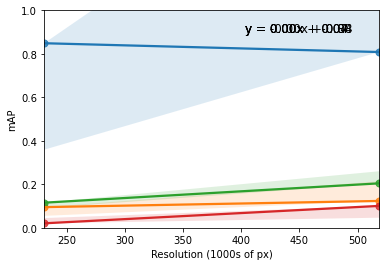

In [121]:
df_res_largefast = pd.DataFrame([df_res.iloc[1], df_res.iloc[2]]) # blue
df_res_largeslow = pd.DataFrame([df_res.iloc[4], df_res.iloc[5]]) # orange
df_res_smallfast = pd.DataFrame([df_res.iloc[7], df_res.iloc[8]]) # green
df_res_smallslow = pd.DataFrame([df_res.iloc[10], df_res.iloc[11]]) # red

plot_with_best_fit(df_res_largefast, 'Resolution (1000s of px)', 'mAP')
plot_with_best_fit(df_res_largeslow, 'Resolution (1000s of px)', 'mAP')
plot_with_best_fit(df_res_smallfast, 'Resolution (1000s of px)', 'mAP')
plot_with_best_fit(df_res_smallslow, 'Resolution (1000s of px)', 'mAP')

In [138]:
i = 1
for i in range(1, 11, 3):
    print(df_res.iloc[i+1, 11] - df_res.iloc[i, 11])

-0.04047435522079468
0.028389394283294705
0.0888372361660003
0.08009196445345881


0       Video Width (px) Height (px) Frame Rate (fps)  frames  \
12  largefast       1280         720               25   250.0   
13  largefast        640         360               25   250.0   
14  largefast        960         540               25   250.0   
15  largeslow       1280         720               25   250.0   
16  largeslow        640         360               25   250.0   
17  largeslow        960         540               25   250.0   
18  smallfast       1280         720               25   250.0   
19  smallfast        640         360               25   250.0   
20  smallfast        960         540               25   250.0   
21  smallslow       1280         720               25   250.0   
22  smallslow        640         360               25   250.0   
23  smallslow        960         540               25   250.0   

0   runtime (inference)  average time per frame  runtime (total)       energy  \
12           518.927982                2.075712       537.317521  2757.38

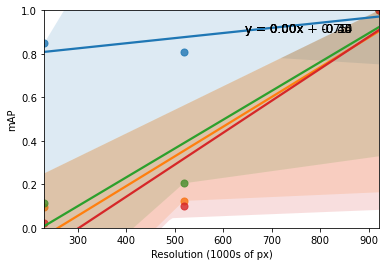

In [98]:
# Show that when changing resolution, larger objects experience less rapid degradation of accuracy compmared to smaller
print(df_res)
df_res_largefast = df_res[df_res['Video'].isin(['largefast'])] # blue
df_res_largeslow = df_res[df_res['Video'].isin(['largeslow'])] # orange
df_res_smallfast = df_res[df_res['Video'].isin(['smallfast'])] # green
df_res_smallslow = df_res[df_res['Video'].isin(['smallslow'])] # red

plot_with_best_fit(df_res_largefast, 'Resolution (1000s of px)', 'mAP')
plot_with_best_fit(df_res_largeslow, 'Resolution (1000s of px)', 'mAP')
plot_with_best_fit(df_res_smallfast, 'Resolution (1000s of px)', 'mAP')
plot_with_best_fit(df_res_smallslow, 'Resolution (1000s of px)', 'mAP')

In [38]:
# Filter to get dfs with same framerate

df = df[df['Frame Rate (fps)'] == 1]
print(df)

for df in dfs:
        print(df)


# plot_with_best_fit(config_data, 'Resolution (1000s of px)', 'energy')

Empty DataFrame
Columns: [Video, Width (px), Height (px), Frame Rate (fps), frames, runtime (inference), average time per frame, runtime (total), energy, avg power, energy per frame, mAP, Resolution (px), Resolution (1000s of px), Energy (1000s of J), Energy (J) per frame]
Index: []
0      Video Width (px) Height (px) Frame Rate (fps)  frames  \
0  largefast       1280         720                1   250.0   

0  runtime (inference)  average time per frame  runtime (total)      energy  \
0            22.173799                0.088695        42.446342  188.990156   

0  avg power  energy per frame       mAP  Resolution (px)  \
0   4.452449          0.755961  0.134405           921600   

0  Resolution (1000s of px)  Energy (1000s of J)  Energy (J) per frame  
0                     921.6              0.18899              0.755961  
0      Video Width (px) Height (px) Frame Rate (fps)  frames  \
0  largefast       1280         720                3   250.0   

0  runtime (inference)  averag

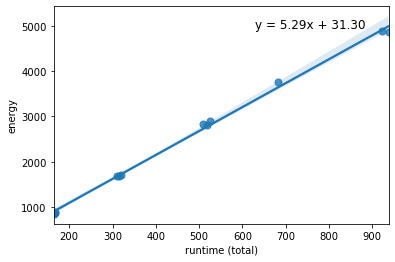

In [70]:
plot_with_best_fit(config_data, 'runtime (total)', 'energy')

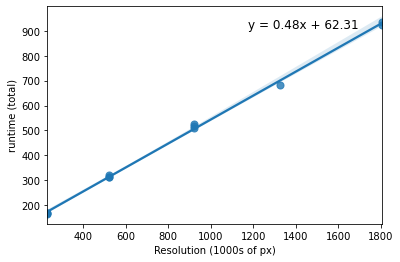

In [71]:
plot_with_best_fit(config_data, 'Resolution (1000s of px)', 'runtime (total)')

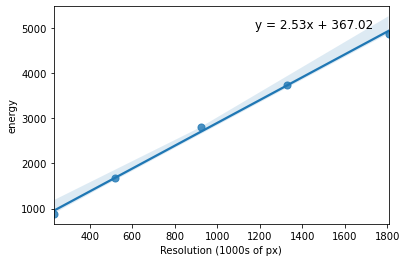

In [88]:
plot_with_best_fit(config_data, 'Resolution (1000s of px)', 'energy', 'sparse')

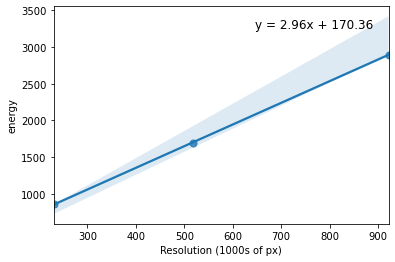

In [89]:
plot_with_best_fit(config_data, 'Resolution (1000s of px)', 'energy', 'medium')

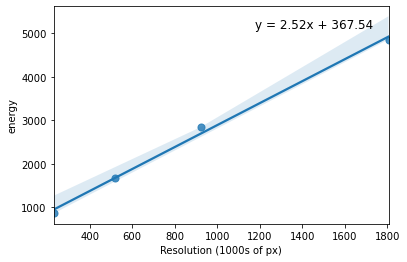

In [90]:
plot_with_best_fit(config_data, 'Resolution (1000s of px)', 'energy', 'noisy')

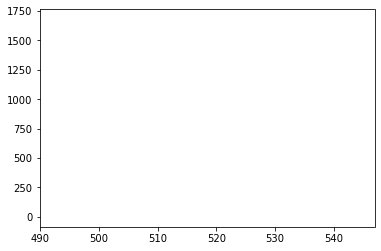